In [1]:
import sys
sys.path.insert(0, '..')
from pkg.nse import nse

In [2]:
import requests,json
import pandas as pd
import datetime
import datetime
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math

#### Fetching all expiries from 2013-2023, Taking only last thrusday expiries

In [4]:
ex=nse.historical_expiry_dates_by_dates("NIFTY",start_date="01-01-2013",end_date="01-01-2024",type="options")
dates = [datetime.datetime.strptime(date, '%d-%b-%Y') for date in ex]
latest_dates = defaultdict(lambda: datetime.datetime.min)
for date in dates:
    month_year = (date.year, date.month)
    if date > latest_dates[month_year]:
        latest_dates[month_year] = date
latest_dates_list = sorted(latest_dates.values())
expiry_dates = [date.strftime('%d-%b-%Y') for date in latest_dates_list]

#### Fetching expiry prices
##### ./checkpoints/nifty_expiry_prices.csv

In [5]:
# symbol = "NIFTY"
# indexType = "NIFTY 50"
# instrumentType = "options"
# optionType="CE"
# exipy_prices={}
# for i in expiry_dates:
#     k=nse.index_history(indexType,(datetime.datetime.strptime(i, '%d-%b-%Y') - datetime.timedelta(days=1)).strftime('%d-%b-%Y'),i)
#     exipy_prices[i]=k[k['HistoricalDate']==k['HistoricalDate'].max()]['CLOSE'][0]

In [34]:
exipy_prices=pd.read_csv("/Users/shubhami/Documents/mine/finance/rough/checkpoints/nifty_expiry_prices.csv")


#### Calculating the day on which we will calculate max pain i.e on expiry -14

In [7]:
days_to_expiry_for_calculation=14

In [8]:
def get_dates_minus_days(date,days_to_expiry_for_calculation):
    date=datetime.datetime.strptime(date, '%d-%b-%Y')
    return (date - datetime.timedelta(days=days_to_expiry_for_calculation+2)).strftime('%d-%m-%Y'),(date - datetime.timedelta(days=days_to_expiry_for_calculation)).strftime('%d-%m-%Y')
pain_start_end_date=[]
for i in expiry_dates:
    pain_start_end_date.append([i,*get_dates_minus_days(i,days_to_expiry_for_calculation)])

#### fetching option chain 

In [9]:
# symbol = "NIFTY"
# # start_date = "26-26-2014"
# # end_date ="26-06-2014"
# instrumentType = "options"
# # expiry_date ="26-Jun-2014"
# # strikePrice = 2700
# optionType="PE"
# for ex, s,e in pain_start_end_date:
#     a=nse.historical_derivative_data(symbol,s,e,instrumentType,ex,"",optionType)
#     a[a['FH_TIMESTAMP']==a['FH_TIMESTAMP'].max()].to_csv("./checkpoints/maxpain/nifty/"+'-'.join(ex.split('-')[::-1])+"-OI-PE.csv", encoding='utf-8')
#     print('-'.join(ex.split('-')[::-1]),a['FH_TIMESTAMP'].max())


#### plotting the max pain

In [10]:
def plot_max_pain(dictonary,max_pain_point,actual_expiry_price=0):
    strike=dictonary.keys()
    profit=dictonary.values()
    buffer_point = round((max_pain_point *1.05) / 100) *100
    top_y_value = max(profit) * 1.1 
    plt.plot(strike, profit, marker='.')
    plt.plot(max_pain_point, min(profit), 'ro', label='Max PAIN POINT @ {}'.format(max_pain_point))
    plt.plot(buffer_point, min(profit), 'bo', label='With ~5% buffer @ {}'.format(buffer_point))
    plt.fill_between(strike, profit, where=[s <= max_pain_point for s in strike], color='red', alpha=0.3, label='CE write')
    plt.fill_between(strike, profit, where=[s >= buffer_point for s in strike], color='red', alpha=0.3)
    plt.fill_between(strike, profit, where=[max_pain_point <= s <= buffer_point for s in strike], color='green', alpha=0.5, label='Expected Expiry')
    if actual_expiry_price:
        plt.plot(actual_expiry_price, min(profit), 'go', label='Actual Expiry Price {}'.format(actual_expiry_price))
    plt.xlabel('STRIKE')
    plt.ylabel('PROFIT')
    plt.title('Plotting for MAXPAIN')
    plt.legend()
    plt.show()


In [11]:
def ce_profit(strike,stock):
    result = float(stock)-float(strike)
    return max(result, 0) 

def pe_profit(strike,stock):
    result = float(strike)-float(stock)
    return max(result, 0)   

def get_max_pain_point(c,p):
    def ce_operation(strike,OI,stock):
        profit=ce_profit(strike,stock)
        return int(OI) * profit
    def pe_operation(strike,OI,stock):
        profit=pe_profit(strike,stock)
        return int(OI) * profit
    profit={}
    for s in c['FH_STRIKE_PRICE']:
        profit[s]=sum(c.apply(lambda row:ce_operation(row['FH_STRIKE_PRICE'],row['FH_OPEN_INT'],s), axis=1))+sum(p.apply(lambda row:pe_operation(row['FH_STRIKE_PRICE'],row['FH_OPEN_INT'],s), axis=1))
    return min(profit, key=(lambda x: profit[x])),profit

In [15]:
ex_strikes=[]
ex_pain_point=[]
pcr=[]
for ex in expiry_dates:
    c=pd.read_csv("/Users/shubhami/Documents/mine/finance/rough/checkpoints/maxpain/nifty/"+'-'.join(ex.split('-')[::-1])+"-OI-CE.csv")
    p=pd.read_csv("/Users/shubhami/Documents/mine/finance/rough/checkpoints/maxpain/nifty/"+'-'.join(ex.split('-')[::-1])+"-OI-PE.csv")
    point,d=get_max_pain_point(c,p)
    ex_strikes.append(d)
    ex_pain_point.append(point)
    pcr.append(sum(p['FH_OPEN_INT'])/sum(c['FH_OPEN_INT'])


NameError: name 'mp15' is not defined

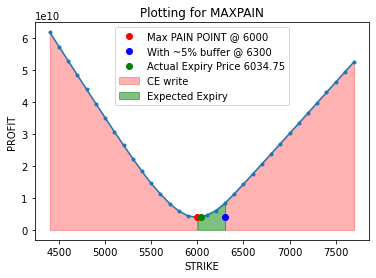

In [19]:
    
mp14 = pd.DataFrame(list(zip(exipy_prices['expiry_date'], exipy_prices['price'],ex_pain_point,pcr)), columns = ['expiry', 'settlement','maxpain','pcr'])
mp14['diff']=((mp14['settlement']-mp14['maxpain'])/mp14['maxpain'])*100

#removing one outlier for march-2020 covid
mp14=mp14[mp14['diff']>-8]
plot_max_pain(ex_strikes[0],ex_pain_point[0],exipy_prices['price'][0])


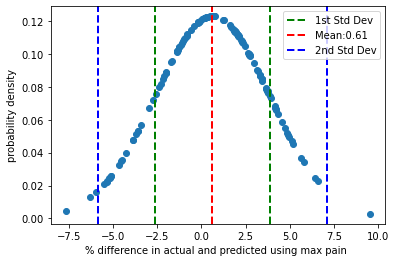

In [23]:

def normal_pdf(x, mu=0, sigma=1):
    sqrt_two_pi = math.sqrt(math.pi * 2)
    return np.exp(-(x - mu) ** 2 / 2 / sigma ** 2) / (sqrt_two_pi * sigma)
def plot_normal_diff(distribution):
    mean = distribution.mean()
    std = distribution.std()
    first_std_range = (mean - std, mean + std)
    second_std_range = (mean - 2*std, mean + 2*std)

    plt.scatter(distribution,normal_pdf(distribution,mean,std) )
    plt.axvline(first_std_range[0], color='g', linestyle='--', linewidth=2, label='1st Std Dev')
    plt.axvline(first_std_range[1], color='g', linestyle='--', linewidth=2)
    plt.axvline(mean, color='r', linestyle='--', linewidth=2, label='Mean:'+str(mean)[:4])
    plt.axvline(second_std_range[0], color='b', linestyle='--', linewidth=2, label='2nd Std Dev')
    plt.axvline(second_std_range[1], color='b', linestyle='--', linewidth=2)
    plt.xlabel('% difference in actual and predicted using max pain ')
    plt.ylabel('probability density')
    plt.legend()
    plt.show()

plot_normal_diff(mp14['diff'])



In [24]:
from statistics import NormalDist
print(NormalDist(mu=mp14['diff'].mean(), sigma=mp14['diff'].std()).cdf(5.0))
print(NormalDist(mu=mp14['diff'].mean(), sigma=mp14['diff'].std()).cdf(2.79))

0.9115306365387916
0.7484733142308757


# year wise analsis

,expiry,MaxPain
0,2013,90.208785
1,2014,91.872022
2,2015,93.094075
3,2016,93.109023
4,2017,95.501781
5,2018,92.884080
6,2019,90.403570
7,2020,72.090980
8,2021,95.841663
9,2022,92.285914


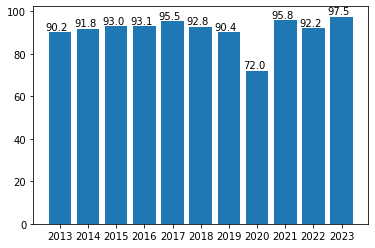

In [96]:

yearly_expiry_dates=defaultdict(lambda:list())
for i in expiry_dates:
    yearly_expiry_dates[i[-4:]].append(i)
yearly_mp={}
for i in list(yearly_expiry_dates.keys())[:-1]:
    ex_strikes=[]
    ex_pain_point=[]
    pcr=[]
    for ex in yearly_expiry_dates[i]:
        c=pd.read_csv("/Users/shubhami/Documents/mine/finance/rough/checkpoints/maxpain/nifty/"+'-'.join(ex.split('-')[::-1])+"-OI-CE.csv")
        p=pd.read_csv("/Users/shubhami/Documents/mine/finance/rough/checkpoints/maxpain/nifty/"+'-'.join(ex.split('-')[::-1])+"-OI-PE.csv")
        point,d=get_max_pain_point(c,p)
        ex_strikes.append(d)
        ex_pain_point.append(point)
        pcr.append(sum(p['FH_OPEN_INT'])/sum(c['FH_OPEN_INT']))
    mp = pd.DataFrame(list(zip(yearly_expiry_dates[i],exipy_prices[exipy_prices['expiry_date'].str.endswith(i)]['price'] ,ex_pain_point,pcr)), columns = ['expiry', 'settlement','maxpain','pcr'])
    mp['diff']=((mp['settlement']-mp['maxpain'])/mp['maxpain'])*100
    mp=mp[mp['diff']>-8]
    yearly_mp[i]=mp

#removing one outlier for march-2020 covid
yearly_results=pd.DataFrame(list(zip(yearly_mp.keys(),[NormalDist(mu=yearly_mp[i]['diff'].mean(), sigma=yearly_mp[i]['diff'].std()).cdf(5)*100 for i in yearly_mp.keys()])),columns = ['expiry', 'MaxPain'])
bars=plt.bar(yearly_results.expiry, yearly_results.MaxPain)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x()-0.1, yval + 1, str(yval)[:4])
yearly_results

# month wise analsis

,expiry,MaxPain
0,Jan,91.617303
1,Feb,97.086806
2,Mar,90.605428
3,Apr,78.664554
4,May,92.872324
5,Jun,97.962943
6,Jul,88.729993
7,Aug,93.003948
8,Sep,95.960972
9,Oct,88.152115


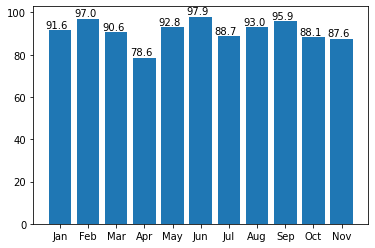

In [107]:
monthly_expiry_dates=defaultdict(lambda:list())
for i in expiry_dates:
    monthly_expiry_dates[i[3:-5]].append(i)
monthly_mp={}
for i in list(monthly_expiry_dates.keys())[:-1]:
    ex_strikes=[]
    ex_pain_point=[]
    pcr=[]
    for ex in monthly_expiry_dates[i]:
        c=pd.read_csv("/Users/shubhami/Documents/mine/finance/rough/checkpoints/maxpain/nifty/"+'-'.join(ex.split('-')[::-1])+"-OI-CE.csv")
        p=pd.read_csv("/Users/shubhami/Documents/mine/finance/rough/checkpoints/maxpain/nifty/"+'-'.join(ex.split('-')[::-1])+"-OI-PE.csv")
        point,d=get_max_pain_point(c,p)
        ex_strikes.append(d)
        ex_pain_point.append(point)
        pcr.append(sum(p['FH_OPEN_INT'])/sum(c['FH_OPEN_INT']))
    mp = pd.DataFrame(list(zip(monthly_expiry_dates[i],exipy_prices[exipy_prices['expiry_date'].str.contains(i)]['price'] ,ex_pain_point,pcr)), columns = ['expiry', 'settlement','maxpain','pcr'])
    mp['diff']=((mp['settlement']-mp['maxpain'])/mp['maxpain'])*100
    mp=mp[mp['diff']>-8]
    monthly_mp[i]=mp

#removing one outlier for march-2020 covid
monthly_results=pd.DataFrame(list(zip(monthly_mp.keys(),[NormalDist(mu=monthly_mp[i]['diff'].mean(), sigma=monthly_mp[i]['diff'].std()).cdf(5)*100 for i in monthly_mp.keys()])),columns = ['expiry', 'MaxPain'])
bars=plt.bar(monthly_results.expiry, monthly_results.MaxPain)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x()-0.1, yval + 1, str(yval)[:4])
monthly_results

### Instant maxpain point calculator

In [63]:
symbol = "NIFTY"
start_date = "30-05-2024"
end_date ="01-06-2024"
instrumentType = "options"
expiry_date ="27-Jun-2024"
c=nse.historical_derivative_data(symbol,start_date,end_date,instrumentType,expiry_date,"","CE")
p=nse.historical_derivative_data(symbol,start_date,end_date,instrumentType,expiry_date,"","PE")
c=c[c['FH_TIMESTAMP']==c['FH_TIMESTAMP'].max()]
p=p[p['FH_TIMESTAMP']==p['FH_TIMESTAMP'].max()]
point,d=get_max_pain_point(c,p)
max_pain_point_with_buffer=round((float(point)*1.05)/100)*100
max_pain_point_with_buffer

23700

In [84]:
lotsize=25
profit= float(c[c['FH_STRIKE_PRICE']=="%.2f" % max_pain_point_with_buffer]['FH_CLOSING_PRICE'].values[0]) *lotsize
profit

4530.0

In [97]:

BASE_URL = 'https://zerodha.com/margin-calculator/SPAN'
data={
"action": "calculate",
"exchange[]": "NFO",
"product[]": "OPT",
"scrip[]": "NIFTY24JUN",
"option_type[]": "CE",
"strike_price[]": str(max_pain_point_with_buffer),
"qty[]": "25",
"trade[]": "sell"
}
session = requests.Session()
res = session.post(BASE_URL, data=data)
data = res.json()
data['last']

{'span': 32134,
 'exposure': 11265.35,
 'netoptionvalue': 4530,
 'spread': 0,
 'total': 43399.35}

# rough

### s=nse.nsefetch('https://www.nseindia.com/api/historical/foCPV?from=01-04-2014&to=26-06-2014&instrumentType=OPTIDX&symbol=NIFTY&year=2014&strikePrice=2700.00&expiryDate=26-Jun-2014&optionType=CE&csv=true')
s=nse.nsefetch('https://www.nseindia.com/api/historical/foCPV?from=25-06-2014&to=26-06-2014&instrumentType=OPTIDX&symbol=NIFTY&expiryDate=26-Jun-2014&optionType=CE&csv=true')
s=pd.DataFrame.from_records(s["data"])

In [157]:
scp=[]
fcp=[]
for ex in expiry_dates:
    if ex!='26-Mar-2020':
        f=pd.read_csv("/Users/shubhami/Documents/mine/finance/rough/checkpoints/maxpain/nifty/"+'-'.join(ex.split('-')[::-1])+"-OI-CE.csv")
        s=pd.read_csv("/Users/shubhami/Documents/mine/finance/rough/checkpoints/maxpain/nifty/"+'-'.join(ex.split('-')[::-1])+"-OI-CE-7.csv")
        bufffer=mp[mp['expiry']==ex]['maxpain'].values[0]
        bufffer=round((bufffer*1.05)/100)*100
        scp.append(s[s['FH_STRIKE_PRICE']==bufffer]['FH_CLOSING_PRICE'].values[0])
        bufffer=mp15[mp15['expiry']==ex]['maxpain'].values[0]
        bufffer=round((bufffer*1.05)/100)*100
        fcp.append(f[f['FH_STRIKE_PRICE']==bufffer]['FH_CLOSING_PRICE'].values[0])
    

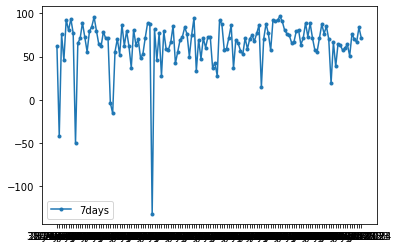

In [166]:
plt.plot(mp['expiry'], [(x-y)*100/x for x,y in zip(fcp,scp)], marker='.',label='7days')
# plt.plot(mp['expiry'], fcp, marker='.',label='14days')
plt.legend()
plt.show()

In [170]:
fs=np.array([(x-y)*100/x for x,y in zip(fcp,scp)])
fs.mean(),fs.std()

(64.1936399522515, 28.9428715833926)

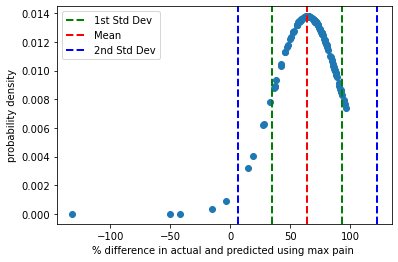

In [175]:
plot_normal_diff(fs)


In [179]:
print(1-NormalDist(mu=fs.mean(), sigma=fs.std()).cdf(0))
print(NormalDist(mu=fs.mean(), sigma=fs.std()).cdf(500))

0.9867206410574914
1.0


In [180]:
print(NormalDist(mu=mp['diff'].mean(), sigma=mp['diff'].std()).cdf(5))
print(NormalDist(mu=mp15['diff'].mean(), sigma=mp15['diff'].std()).cdf(5))

0.9687641632145112
0.9115306365387916
